# Road Surface Sediment Storage
Amanda Manaster  
*2019.09.23*  

---
When a truck passes, two processes occur: **crushing and pumping**.  
    &emsp;*Crushing* creates more fine sediment in the existing sediment matrix by breaking down larger particles.  
    &emsp;*Pumping* makes fine sediment available for transport (i.e., adds the fine sediment to the transport available fines storage layer). 

We can think of the total storage as:  
$S=S_f+S_s+S_b$  
    &emsp;$S_f$= transport available fines (TAF) storage term [$m$]  
    &emsp;$S_s$= surfacing storage term; combination of fines ($S_{s_f}$), coarse particles ($S_{s_c}$) [$m$]  
    &emsp;$S_b$= ballast storage term; combination of fines, 20-30% ($S_{b_f}$), large rocks, 70-80% ($S_{b_r}$) [$m$]  

And the net mass balance as:  
$∆S=-\frac{V_{s,out}}{A}=-H_{s,out}$

$∆S$ = total change in storage [$m$]  
$V_{s,out}$ = lithified equivalent volume of sediment leaving the road prism [$m^3$]  
$A$ = representative area of road [$m^2$]  
$H_{s,out}$ = lithified equivalent depth of sediment leaving the road prism [$m$]    

---
## A Tri-Layered Conceptualization:
![](TruckPass_TriLayer_Labels.png)  

---  
First, load in packages:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from jupyterthemes import jtplot
jtplot.style(ticks=False, grid=True)

Instantiate empty lists for model run:

In [2]:
L = 4.57 #representative segment of road, m

depth = []
rainfall = []
t = []
len_s = []
truck_pass = []
t_s = []

model_end = 52560 #hours == 6 years

Run a model loop to generate random rainfall based on averages from Peter Eagleson's _Ecohydrology_ and to generate stochastic truck passes:

In [3]:
np.random.seed(1) #Use seed to ensure consistent results with each run
time = 0
T_b = 0
T_r = 0

while time < model_end:
    truck = 0
    time_loop = T_b+T_r
    
    T_b = np.random.exponential(90.5) #average inter-storm duration
    T_r = np.random.exponential(2.705) #average storm duration
    r = np.random.exponential(4)      #average intensity
    
    if time_loop/24 >= 1:
        day = int(time_loop/24)
        frac_day = time_loop/24 - int(time_loop/24)
        
        for num in range(day):
            truck += np.random.randint(0,10)
            
        truck += round(np.random.randint(0,10)*frac_day)
    else:
        frac_day = time_loop/24 - int(time_loop/24)
        truck = round(np.random.randint(0,10)*frac_day)
    
    len_s.append(T_r)
    depth.append(r*T_r)
    rainfall.append(r)
    t_s.append(time_loop)
    t.append(time)
    truck_pass.append(truck)
    
    time += T_b + T_r

Because we have a hefty data set, we wrap these data in a Pandas dataframe for ease of plotting.

In [4]:
df = pd.DataFrame() #Create dataframe

df['time'] = t
df['t_s'] =t_s
df['day'] = np.divide(t,24).astype('int64')
df['storm_depth'] = depth
df['rainfall_rate'] = rainfall
df['storm_length'] = len_s
df['truck_pass'] = truck_pass

day0 = datetime(2018, 10, 1)
df.set_index(pd.DatetimeIndex([day0+timedelta(hours=time) for time in df.time]), inplace=True) #Set index of dataframe

df.head()

,time,t_s,day,storm_depth,rainfall_rate,storm_length,truck_pass
2018-10-01 00:00:00.000000,0.000000,0.000000,0,0.001577,0.000458,3.446509,0
2018-10-03 04:16:51.013493,52.280837,52.280837,2,0.216067,0.824459,0.262071,15
2018-10-03 18:54:22.054749,66.906126,14.625289,2,3.023299,2.973959,1.016591,1
2018-10-10 21:24:47.729519,237.413258,170.507132,9,3.724428,2.253381,1.652818,46
2018-10-20 05:03:34.361030,461.059545,223.646287,19,33.832446,7.078506,4.779603,52


We resample the data to get a daily time step.

In [5]:
df2 = df.resample('D').sum().fillna(0)
df2.truck_pass = df2.truck_pass.round()
df2['day'] = np.arange(0, len(df2), 1)
df2.head()

,time,t_s,day,storm_depth,rainfall_rate,storm_length,truck_pass
2018-10-01,0.000000,0.000000,0,0.001577,0.000458,3.446509,0
2018-10-02,0.000000,0.000000,1,0.000000,0.000000,0.000000,0
2018-10-03,119.186963,66.906126,2,3.239366,3.798417,1.278662,16
2018-10-04,0.000000,0.000000,3,0.000000,0.000000,0.000000,0
2018-10-05,0.000000,0.000000,4,0.000000,0.000000,0.000000,0


And now we can plot the stochastically generated daily rainfall.

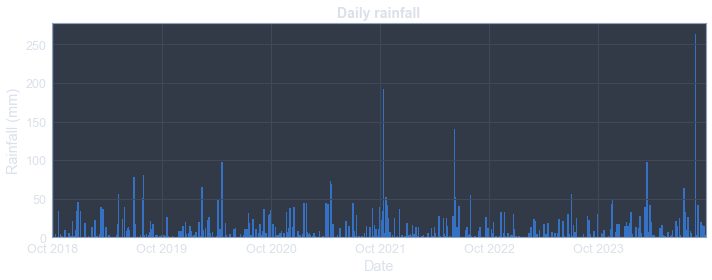

In [6]:
ticklabels = [item.strftime('%b %Y') for item in df2.index[::366]]
fig, ax = plt.subplots(figsize=(10,4))
df2.plot(y='storm_depth', ax=ax, legend=False, kind='bar', width=5)
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Daily rainfall', fontweight='bold', fontsize=14)
plt.xticks(np.arange(0,366*len(ticklabels),366), ticklabels, rotation=0)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\Rainfall.png', dpi=300)
plt.show()

Now that we have the time step of the model, our rainfall, and our truck passes, we can start to calculate sediment transport rates:

In [7]:
#Define constants
rho_w = 1000 #kg/m^3
rho_s = 2650 #kg/m^3
g = 9.81 #m/s^2
S = 0.0825 #m/m; 8% long slope, 2% lat slope
tau_c = 0.094 #N/m^2; assuming d50 is approx. 0.058 mm; value from https://pubs.usgs.gov/sir/2008/5093/table7.html
d50 = 5.8e-5 #m
n = 0.03 #approx Manning's n value for overland flow

#Calculate water depth assuming uniform overland flow
H = ((n*df.rainfall_rate*2.77778e-7*L)/(S**(1/2)))**(3/5)

#Calculate shear stress
df['shear_stress'] = rho_w*g*(H)*S

In [8]:
#Calculate sediment transport rate
df['q_s'] = ((10**(-4.348))/(rho_s*(d50**(0.811))))*(df.shear_stress-tau_c)**(2.457)
df.fillna(0, inplace=True) #Get rid of NaNs

df.head()

,time,t_s,day,storm_depth,rainfall_rate,storm_length,truck_pass,shear_stress,q_s
2018-10-01 00:00:00.000000,0.000000,0.000000,0,0.001577,0.000458,3.446509,0,0.000600,0.000000e+00
2018-10-03 04:16:51.013493,52.280837,52.280837,2,0.216067,0.824459,0.262071,15,0.053868,0.000000e+00
2018-10-03 18:54:22.054749,66.906126,14.625289,2,3.023299,2.973959,1.016591,1,0.116313,4.046033e-09
2018-10-10 21:24:47.729519,237.413258,170.507132,9,3.724428,2.253381,1.652818,46,0.098476,7.811961e-11
2018-10-20 05:03:34.361030,461.059545,223.646287,19,33.832446,7.078506,4.779603,52,0.195701,1.681169e-07


In [9]:
#Resample to daily data again
df3 = df.resample('D').sum().fillna(0)
df3['day'] = np.arange(0, len(df3), 1)

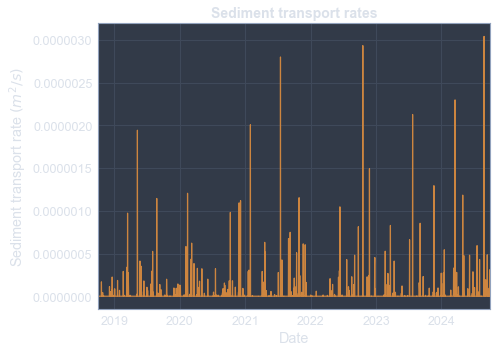

In [10]:
#Plot sediment transport rates over time
fig2, ax2 = plt.subplots(figsize=(7,5))
df3.plot(y='q_s', ax=ax2, color = 'peru', legend=False)
plt.xlabel('Date')
plt.ylabel(r'Sediment transport rate $(m^2/s)$')
plt.title('Sediment transport rates', fontweight='bold', fontsize=14)
plt.tight_layout()
#plt.savefig(r'C:\Users\Amanda\Desktop\Sediment.png', dpi=300)
plt.show()

And finally, we can look at the evolution of the road through time!

## Create loop that goes through model time:
1. Create fines storage, $S_{f_0}$; surfacing storage, $S_{s_0}$; and ballast storage, $S_{b_0}$:  
    &emsp;$S_{f_{0}} = 0$  
    
    &emsp;$S_{s_0}=S_{{sc}_0}+S_{{sf}_0}$     
    &emsp;&emsp;$S_{s_{f_0}}=h_{s_0}*f_{sf_0}*(1-p_s)$   
    &emsp;&emsp;$S_{s_{c_0}}=h_{s_0}*f_{sc_0}*(1-p_s)$  
    
    &emsp;$S_{b_0}=S_{{bf}_0}+S_{{br}_0}$  
    &emsp;&emsp;$S_{{bf}_0}=h_{b_0}*f_{bf_0}*(1-p_b)$   
    &emsp;&emsp;$S_{{br}_0}=h_{b_0}*f_{br_0}*(1-p_b)$  


2. Loop through dataframe:
    * Calculate $S_{f_i}$  
        * Check if available sediment is greater than transport capacity:
            * If *yes*, **condition 1** applies:  
              $H_{s,out_i}=\frac{q_{s_i}*t_{s_i}}{L}$    
              $∆S_{f_i}=u_p*n_i-H_{s,out_i}$     
              
            * If *no*, **condition 2** applies:    
              $H_{s,out_i}=min(u_p*n_i+S_{f_i},\frac{q_{s_i}*t_{s_i}}{L})$  
              $∆S_{f_i}=u_p*n_i-H_{s,out_i}$  
              
        * Update the fines storage term:  
           $S_{f_{i}} = S_{f_{i-1}} + \Delta S_{f_{i}}$  
               
    * Calculate $S_{s_i}$  
       $S_{s_i} = S_{sc_i} + S_{sf_i}$  
       $S_{sc_i}=e^{-kn_i}\left(S_{sc_{i-1}}+\frac{u_c}{k}\right)-\frac{u_c}{k}$  
       $S_{sf_i}={{(1-e}^{-kn_i})(S}_{sc_{i-1}}+\frac{u_c}{k})-n_i\left(u_c+u_p-u_f\right)+S_{sf_{i-1}}$  
    * Calculate $S_{b_i}$  
       $S_{b_i}= n_i(u_c - u_f)+ S_{b_{i-1}}$
       
    
For simplicity, we'll assume the following:  
    &emsp;$h_{s_0}$ = 0.23 [m] (https://www.fhwa.dot.gov/construction/pubs/ots15002.pdf, A4 Table 3)   
    &emsp;$f_{sf_0}$ = 0.275 [-] (from Palix watershed analysis)  
    &emsp;$f_{sc_0}$ = 0.725 [-] (from Palix watershed analysis)  
    &emsp;$p_s$ = 0.275 [-] (Applied Hydrogeology 3rd Ed. by C.W. Fetter, Table 3.4)   
    &emsp;$h_{b_0}$ = 0.60 [m]  
    &emsp;$f_{bf_0}$ = 0.20 [-]  
    &emsp;$f_{br_0}$ = 0.80 [-]  
    &emsp;$p_b$ = 0.20 [-]  

In [11]:
#define constants
h_s = 0.23
f_sf = 0.275
f_sc = 0.725
#p_s = 0.275

h_b = 0.60
f_bf = 0.20
f_br = 0.80
#p_b = 0.20

#The following four constants can be adjusted based on observations
kas = 1.37e-8 #crushing constant... value is easily changeable
kab = 1e-8
u_p = 9.38e-6 #m (4.29e-5m^3/4.57 m^2)  6 tires * 0.225 m width * 0.01 m length * 3.175e-3 m treads
u_f = 1e-6 #m
#u_c = 1.0e-8 #m

In [12]:
#Create a new dataframe for our storage calculations
df_storage = pd.DataFrame()

df_storage['time'] = t
df_storage['day'] = np.divide(t,24).astype('int64')
day0 = datetime(2018, 10, 1)
df_storage.set_index(pd.DatetimeIndex([day0+timedelta(hours=time) for time in df_storage.time]), inplace=True)

In [13]:
#Step 1!
#Initialize numpy arrays for calculations
dS_f = np.zeros(len(df))
S_f = np.zeros(len(df))
S_s = np.zeros(len(df))
S_sc = np.zeros(len(df))
S_sf = np.zeros(len(df))
S_b = np.zeros(len(df))
S_bc = np.zeros(len(df))
S_bf = np.zeros(len(df))
Hs_out = np.zeros(len(df))
n_tp = df.truck_pass.to_numpy()
t = df.t_s.to_numpy()
t_storm = df.storm_length.to_numpy()
q_s = df.q_s.to_numpy()

q_f1 = np.zeros(len(df))
q_f2 = np.zeros(len(df))
q_as = np.zeros(len(df))
q_ab = np.zeros(len(df))


#Initial conditions for fines, surfacing, ballast
S_f[0] = 0
S_s[0] = h_s*(f_sf + f_sc)
S_sc[0] = h_s*(f_sc)
S_sf[0] = h_s*(f_sf)
S_b[0] = h_b*(f_bf + f_br)
S_bc[0] = h_b*(f_br)
S_bf[0] = h_b*(f_bf)

#Step 2!
for i in range(1, len(df)):
    q_f1[i] = u_p*(S_sf[i-1]/S_s[i-1])*n_tp[i-1]
    q_f2[i] = u_f*(S_bf[i-1]/S_b[i-1])*n_tp[i-1]
    q_as[i] = kas*(S_sc[i-1]/S_s[i-1])*n_tp[i-1]
    q_ab[i] = kab*(S_bc[i-1]/S_b[i-1])*n_tp[i-1]
    
    S_bc[i] = S_bc[i-1] - q_ab[i]
    S_sc[i] = S_sc[i-1] - q_as[i]
    
    S_bf[i] = S_bf[i-1] + q_ab[i] - q_f2[i]
    S_sf[i] = S_sf[i-1] + q_as[i] - q_f1[i] + q_f2[i]
        
    S_s[i] = S_sc[i] + S_sf[i]
    S_b[i] = S_bc[i] + S_bf[i]
     
    #Create a condition column based on sediment transport capacity vs sediment supply
    sed_avail[i] = q_f1[i]
    sed_cap[i] = (t_storm[i]*3600*q_s[i])/L
    value[i] = (sed_avail[i]-sed_cap[i])
        
    if value[i] < 0:
        Hs_out[i] = np.minimum(q_f1[i]+S_f[i-1], sed_cap[i])
        dS_f[i] = q_f1[i] - Hs_out[i]

    else:
        Hs_out[i] = sed_cap[i]
        dS_f[i] = q_f1[i] - Hs_out[i]

    S_f[i] = S_f[i-1] + dS_f[i] if (S_f[i-1] + dS_f[i]) > 0 else 0

#Add all numpy arrays to the Pandas dataframe
df_storage['dS_f'] = dS_f
df_storage['S_f'] = S_f
df_storage['S_s'] = S_s
df_storage['S_sc'] = S_sc
df_storage['S_sf'] = S_sf
df_storage['S_b'] = S_b
df_storage['Hs_out'] = Hs_out

NameError: name 'sed_avail' is not defined

In [ ]:
#Look at our dataframe
df_storage.head()

Now, let's plot our data:

In [ ]:
df4 = df_storage.resample('D').mean().fillna(method='ffill')
df4['day'] = np.arange(0, len(df4), 1)
df4['S_f_mm'] = df4.S_f*1000

In [ ]:
fig3, ax3 = plt.subplots(figsize=(7,5))
df4.plot(y='S_f_mm', ax=ax3, color = 'mediumseagreen', legend=False)
plt.xlabel('Date')
plt.ylabel(r'Fine sediment storage $(mm)$')
plt.title('Fine sediment storage', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
df5 = df_storage.resample('H').mean().fillna(method='ffill')
df5['hour'] = np.arange(0, len(df5), 1)

In [ ]:
fig5, ax5 = plt.subplots(3, figsize=(8,10), sharex = 'col', gridspec_kw={'hspace': 0.05})

df5.plot(y='S_s', ax=ax5[0], color = 'mediumpurple', legend=False)
ax5[0].set(ylabel=r'Total surfacing $(m)$')
ax5[0].set_title('Surfacing storage', fontweight='bold', fontsize=14)

df5.plot(y='S_sc', ax=ax5[1], color = 'cornflowerblue', legend=False)
ax5[1].set(ylabel=r'Coarse surfacing $(m)$')

df5.plot(y='S_sf', ax=ax5[2], color = 'salmon', legend=False)
ax5[2].set(ylabel=r'Fine surfacing $(m)$')
plt.xlabel('Date')

plt.show()

In [ ]:
fig7, ax7 = plt.subplots(figsize=(7,5))
df5.plot(y='S_b', ax=ax7, color = 'teal', legend=False)
plt.xlabel('Date')
plt.ylabel(r'Ballast storage $(m)$')
plt.title('Ballast storage', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
#Subset data by water year
yr_1 = df_storage.Hs_out['2018-10-01':'2019-09-30'].sum()
yr_2 = df_storage.Hs_out['2019-10-01':'2020-09-30'].sum()
yr_3 = df_storage.Hs_out['2020-10-01':'2021-09-30'].sum()
yr_4 = df_storage.Hs_out['2021-10-01':'2022-09-30'].sum()
yr_5 = df_storage.Hs_out['2022-10-01':'2023-09-30'].sum()
yr_6 = df_storage.Hs_out['2023-10-01':'2024-09-30'].sum()

#Multiply Hs_out
sed_area = np.multiply([yr_1, yr_2, yr_3, yr_4, yr_5, yr_6], L)
sed_load = np.multiply(sed_area, rho_s)
years = [2019, 2020, 2021, 2022, 2023, 2024]

In [ ]:
fig8, ax8 = plt.subplots(figsize=(7,5))
plt.bar(years, sed_load/(S**2), color = 'mediumvioletred')
plt.xlabel('Water year')
plt.ylabel(r'Sediment load/$LS^2$ $(kg/m)$')
plt.title('Yearly sediment load per meter of road', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

And do a sanity check. (i.e., is mass conserved?)

In [ ]:
sed_sum_m2 = df_storage.Hs_out.sum()
sed_sum_kg_m = sed_sum_m2*rho_s*L
round(sed_sum_kg_m)

In [ ]:
s = (df_storage.S_s[0]-df_storage.S_s[len(df_storage)-1])
b = (df_storage.S_b[0]-df_storage.S_b[len(df_storage)-1])
f = (df_storage.S_f[0]-df_storage.S_f[len(df_storage)-1])

round((s+b+f)*rho_s*L)